In [1]:
import networkx as nx
import numpy as np
import itertools
import math
import matplotlib.pyplot as plt

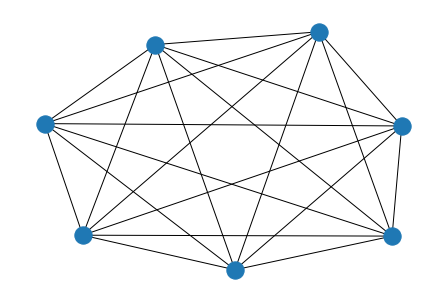

In [2]:
k_n = nx.complete_graph(7)
layout = nx.spring_layout(k_n)
nx.draw(k_n, pos=layout)

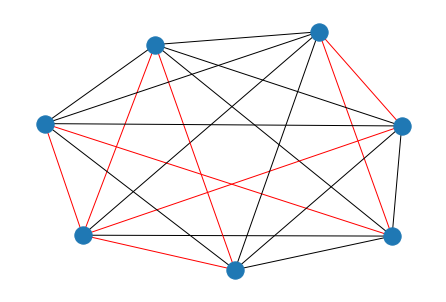

In [3]:
G = nx.Graph()
G.add_edges_from(k_n.edges, color = "black")
ER = nx.erdos_renyi_graph(7,0.5)
G.add_edges_from(ER.edges, color = "red")
colors = nx.get_edge_attributes(G,'color').values()
nx.draw(G,edge_color=colors,pos=layout)

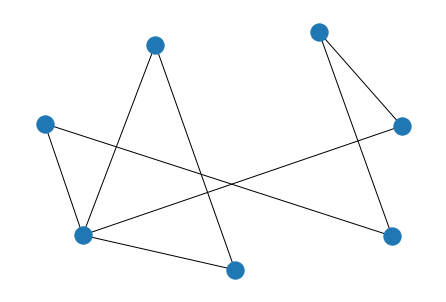

In [4]:
nx.draw(ER,pos=layout)

In [5]:
def random_infection(G, num = 0, ER = None):
    # num: number of edges that are infected at initial state
    # ER: an erdos-renyi graph. Infect the edges in K_n using edges randomly generated by G(n,p)
    if not ER:
        infected_indices = set(np.random.choice(len(G.edges),num,replace=False))
        edges_editable = list(G.edges(data=True))
        for ind in range(len(edges_editable)):
            # list --> make the view object modifiable
            # ind --> ind-th edge
            # 2 --> select the 2-th position in (v_0,v_1,attributes_dict)
            #["color"] --> select the key in the dictionary of attributes
            # "red" --> modify value corresponding to the key "color"
            if ind in infected_indices:
                edges_editable[ind][2]["color"]="red"
            else:
                edges_editable[ind][2]["color"]="black"
    else:
        edges_editable = list(G.edges(data=True))
        for ind in range(len(edges_editable)):
            # list --> make the view object modifiable
            # ind --> ind-th edge
            # 2 --> select the 2-th position in (v_0,v_1,attributes_dict)
            #["color"] --> select the key in the dictionary of attributes
            # "red" --> modify value corresponding to the key "color"
            edges_editable[ind][2]["color"]="black"
        G.add_edges_from(ER.edges, color = "red")
random_infection(G,9, ER)

(0, 1, {'color': 'black'})
(0, 2, {'color': 'black'})
(0, 3, {'color': 'red'})
(0, 4, {'color': 'red'})
(0, 5, {'color': 'black'})
(0, 6, {'color': 'black'})
(1, 2, {'color': 'red'})
(1, 3, {'color': 'red'})
(1, 4, {'color': 'black'})
(1, 5, {'color': 'red'})
(1, 6, {'color': 'red'})
(2, 3, {'color': 'black'})
(2, 4, {'color': 'black'})
(2, 5, {'color': 'red'})
(2, 6, {'color': 'black'})
(3, 4, {'color': 'black'})
(3, 5, {'color': 'black'})
(3, 6, {'color': 'black'})
(4, 5, {'color': 'black'})
(4, 6, {'color': 'red'})
(5, 6, {'color': 'black'})


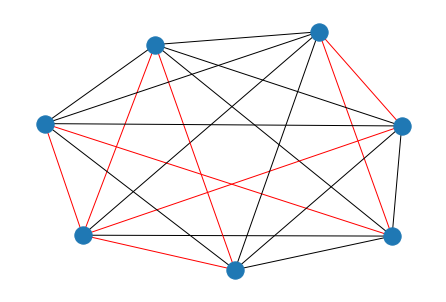

In [6]:
# display infected graph
for i in G.edges(data=True):
    print(i)
colors = nx.get_edge_attributes(G,'color').values()
nx.draw(G,edge_color=colors,pos=layout)

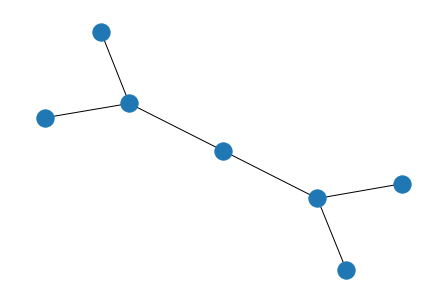

In [7]:
# define H, the subgraph. 
subgraph = nx.balanced_tree(r=2, h=2)
nx.draw(subgraph)

In [8]:
# Todo: the below functions maybe simplied with
# nx.enumerate_all_cliques(G)

In [9]:
def produce_all_connected_subgraphs(G, subgraph):   
    # algorithm 1: find combinations of nodes that match the order of the subgraph.
    # Then for each combination of node, output edges in the complete graph formed by them into a list
    # select all combinations of the same size with the number of edges in the subgraph
    # form the induced subgraph with these edges and then check if the induced subgraph is isomorphic to H
    # if so, store the subgraph for later use
    
    # algorithm 2: find combinations of edges in the original graph that match the number of edges in the subgraph
    # Then for each combination of edges, produce the induced subgraph on these edges
    # check if the induced subgraph is isomorphic to H
    # if so, store the subgraph for later use
    size = len(subgraph.edges)
    all_connected_subgraphs = []
    # combinations of nodes matching the order of the subgraph
    for SG in (G.edge_subgraph(selected_edges) for selected_edges in itertools.combinations(G.edges, size)):
        if nx.is_isomorphic(SG, subgraph):
            all_connected_subgraphs.append(SG)
            
    return all_connected_subgraphs
all_connected_subgraphs = produce_all_connected_subgraphs(G,subgraph)

In [10]:
len(all_connected_subgraphs)

630

In [11]:
# for all sets of nodes then for each edge between two elements
def plot_next_complete(G,subgraph,all_connected_subgraphs,layout,time_step,draw=True):
    if time_step!=0:
        black_edge = 0
        red_edge = 0
        total_edge = len(subgraph.edges)
        uninfected_edge = []
        for i in all_connected_subgraphs:
            black_edge = 0
            red_edge = 0
            target_edge = None
            for e in i.edges(data=True):
                if G[e[0]][e[1]]["color"] == "black":
                    black_edge+=1
                    target_edge = e
                else:
                    red_edge+=1
                if black_edge>=2:
                    break
            if red_edge==total_edge-1:
                uninfected_edge.append(target_edge)
        for e in uninfected_edge:
            G[e[0]][e[1]]["color"] = "red"
    if draw:
        colors = nx.get_edge_attributes(G,'color').values()
        nx.draw(G,edge_color=colors,pos=layout)

def fully_infected(G):
    # return whether G is fully infected, and number of its infected edge
    counts = 0
    fully_infected = True
    for edge in G.edges(data=True):
        if edge[2]["color"]=="black":
            fully_infected = False
        else:
            counts+=1
        
    return fully_infected,counts

In [12]:
def trial(num_iterations,G, subgraph, all_connected_subgraphs, layout,draw=True):
    if draw:
        plt.figure(figsize=(20,20))
    prev_counts = 0
    for i in range(num_iterations):
        if draw:
            plt.subplot(num_iterations//4+1, 4, i+1)
        plot_next_complete(G,subgraph,all_connected_subgraphs,layout,i,draw)
        if draw:
            plt.title(f"Time step {i}")
        infected, cur_counts = fully_infected(G)
        if infected:
            print(f"Fully infected at time step {i}")
            return i, True
        if prev_counts==cur_counts:
            if cur_counts==0:
                print(f"Process converged at time step 0")
                return 0, False
            else:
                print(f"Process converged at time step {i-1}")
                return i-1, False
        prev_counts = cur_counts
        

Fully infected at time step 2


(2, True)

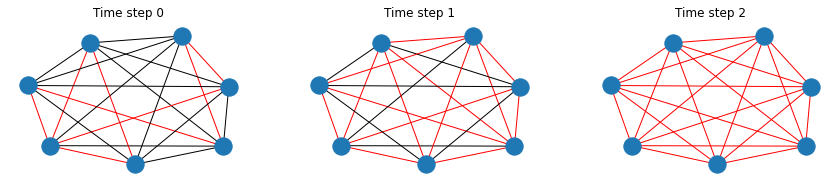

In [13]:
trial(20,G,subgraph,all_connected_subgraphs,layout)

Process converged at time step 0
Wall time: 42.4 s


(0, False)

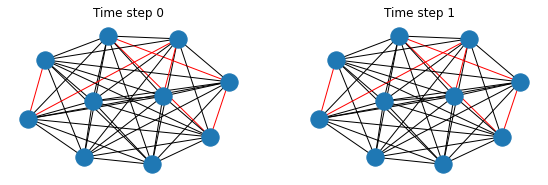

In [14]:
%%time

# usage

# 1. G must be a complete graph, K_n
G = nx.complete_graph(10)  

# 2: Define the initial state. num is the number of initially infected edge G starts with
random_infection(G, num=6)

# 3: Define H. H can be any graph.
H = nx.random_regular_graph(2,5,seed=2)

# 3: Find all combinations of nodes where a complete subgraph can be induced. Note that this part has very bad scalability 
all_connected_subgraphs = produce_all_connected_subgraphs(G, H)

# 4: Perform the H-graph bootstrap percolation process for num_iterations iterations. A fixed layout for consistent visualization.
# The loop will halt once H percolates or the process converges
layout = nx.spring_layout(G)
trial(20, G, H, all_connected_subgraphs, layout)

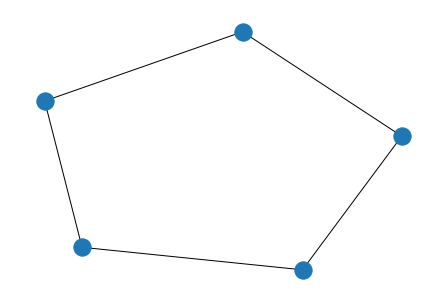

In [15]:
H = nx.random_regular_graph(2,5,seed=2)
nx.draw(H)